In [2]:
import numpy as np
import gzip
import struct

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    


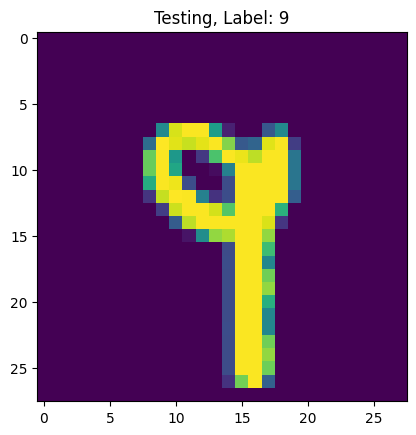

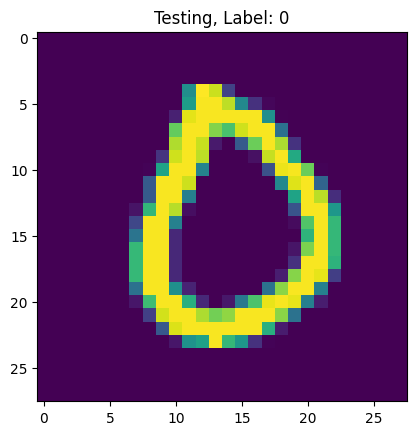

In [3]:
### Data Import ###

import matplotlib.pyplot as plt
import os

NUM_TRAIN_SAMPLES = 60000
NUM_TEST_SAMPLES = 10000

# Assume that files are in current directory
TRAIN_IMAGE_PATH = "train-images-idx3-ubyte.gz"
TRAIN_LABEL_PATH = "train-labels-idx1-ubyte.gz"
TEST_IMAGE_PATH = "t10k-images-idx3-ubyte.gz"
TEST_LABEL_PATH = "t10k-labels-idx1-ubyte.gz"

training_images = read_idx(TRAIN_IMAGE_PATH)
training_labels = read_idx(TRAIN_LABEL_PATH)
testing_images = read_idx(TEST_IMAGE_PATH)
testing_labels = read_idx(TEST_LABEL_PATH)

def print_image_label_pairs(image_dataset, label_dataset, title):
    # Vector to pick random image/label pairs
    random_samples = np.random.randint(0, len(image_dataset), size=2)
    handle = 0  # Generic handle so multiple figs can be created
    
    for idx in random_samples:
        plt.figure(handle)
        handle += 1
        plt.imshow(image_dataset[idx,:,:])
        plt.title("{}, Label: {}".format(title, label_dataset[idx]))

print_image_label_pairs(training_images, training_labels, "Training")
print_image_label_pairs(testing_images, testing_labels, "Testing")


Using the `read_idx()` method to read in raw gzip files. Multiple images are plotted to show image corresponds to proper label.

1.0 0.0


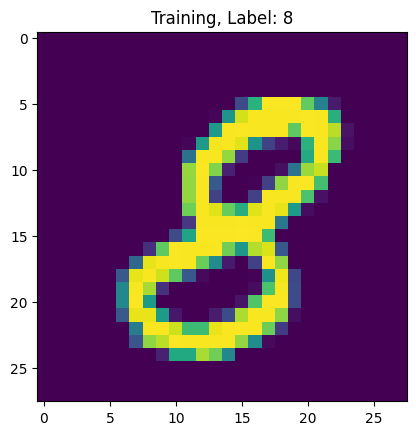

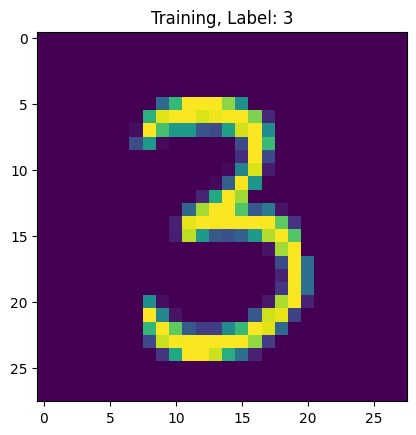

In [4]:
### Normalize Pixels, Categorize Labels ###

def normalize_dataset(data_array):
    a = data_array.min()
    b = data_array.max()
    return (data_array - a)/(b - a)

train_img_norm = normalize_dataset(training_images)
train_label_cat = [int(string_num) for string_num in training_labels]
test_img_norm = normalize_dataset(testing_images)
test_label_cat = [int(string_num) for string_num in testing_labels]

# Make sure data still looks good
print_image_label_pairs(train_img_norm, training_labels, "Training")
# Make sure min and max are within bounds
print(train_img_norm.max(), train_img_norm.min())

### Flatten Data ###

train_img_norm_flat = train_img_norm.reshape((NUM_TRAIN_SAMPLES, 28*28))
test_img_norm_flat = test_img_norm.reshape(NUM_TEST_SAMPLES, 28*28)

Data was normalized using [this function](https://stackoverflow.com/questions/65029540/normalize-dataset-in-python). To confirm that data is properly normalized, the min an max values are inspected (to make sure they're between 1.0 and 0) and the data is plotted for visual confirmation. 
Label data is categorized by converting the sting value for each number into an int value.

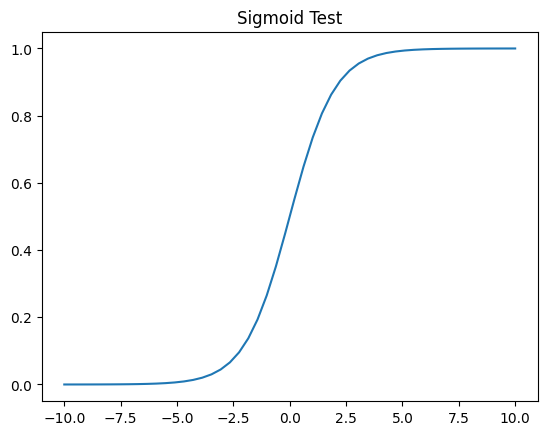

In [5]:
### Feed Forward, Inits ###

# Inits
TEST_SIGMOID = True
np.random.seed(695)
NUM_LAYER_0_NODES = 783
NUM_LAYER_1_NODES = 127
NUM_LAYER_2_NODES = 63
NUM_OUTLAYER_NODES = 10

# Init weight vectors randomly
layer_0_weights = np.random.rand(NUM_LAYER_0_NODES, NUM_LAYER_1_NODES)
layer_0_bias = np.random.rand(NUM_LAYER_0_NODES, NUM_LAYER_1_NODES)
layer_1_weights = np.random.rand(NUM_LAYER_1_NODES, NUM_LAYER_2_NODES)
layer_1_bias = np.random.rand(NUM_LAYER_1_NODES, NUM_LAYER_2_NODES)
layer_2_weights = np.random.rand(NUM_LAYER_2_NODES, NUM_OUTLAYER_NODES)
layer_2_bias = np.random.rand(NUM_LAYER_2_NODES, NUM_OUTLAYER_NODES)

# Sigmoid Function def
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Test Sigmoid Function
if TEST_SIGMOID:
    test_vec = np.linspace(-10,10)
    plt.plot(test_vec, sigmoid(test_vec))
    plt.title("Sigmoid Test")


In [ ]:
def feed_forward_step(input_vec, weight_vec, bias):
    return sigmoid(sum(input_vec * weight_vec) + bias)

def run_feed_forward(training_vec):
    H1_layer = []
    H2_layer = []
    out_layer = []
    num_rows, num_cols = training_vec.shape
    for idx in range(num_cols):
        print(idx)
        for step in range(NUM_LAYER_1_NODES):
            H1_layer.append(feed_forward_step(training_vec[:,idx], layer_0_weights[:,step], layer_0_bias[:,step]))
        for step in range(NUM_LAYER_2_NODES):
            H2_layer.append(feed_forward_step(H1_layer, layer_1_weights[:,step], layer_1_bias[:,step]))
        for step in range(NUM_OUTLAYER_NODES):
            out_layer.append(feed_forward_step(H2_layer, layer_2_weights[:,step], layer_2_bias[:,step]))
    return out_layer
        
run_feed_forward(train_img_norm_flat[0:1,:])

In [ ]:
training_vec.shape
    for idx in range(num_cols):
        print(idx)
        for step in range(NUM_LAYER_1_NODES):
            H1_layer.append(feed_forward_step(training_vec[:,idx], layer_0_weights[:,step], layer_0_bias[:,step]))
        for step in range(NUM_LAYER_2_NODES):
            H2_layer.append(feed_forward_step(H1_layer, layer_1_weights[:,step], layer_1_bias[:,step]))
        for step in range(NUM_OUTLAYER_NODES):
            out_layer.append(feed_forward_step(H2_layer, layer_2_weights[:,step], layer_2_bias[:,step]))
    return out_layer
        
run_feed_forward(train_img_norm_flat[0,:])

In [ ]:
def catergorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1-1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped))/n_samples
    

In [ ]:
### Network Initialization, Training ###

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver="sgd", 
                    alpha=1e-5,
                    hidden_layer_sizes=(128,64),
                    random_state=695)

clf.fit(train_img_norm_flat, train_label_cat)
print(clf.coefs_)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(128, 64), random_state=695,
              solver='lbfgs')

This step leverages the [MLPClassifier from sklearn](https://scikit-learn.org/1.5/modules/neural_networks_supervised.html). This is trained over the training data (which has been flattened) and training labels (which have been categorized). the `fit()` method generates the model, which is used for the later steps. The weights for each node can be displayed using `clf.coefs_`

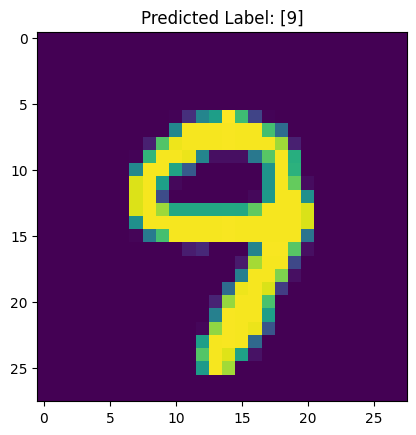

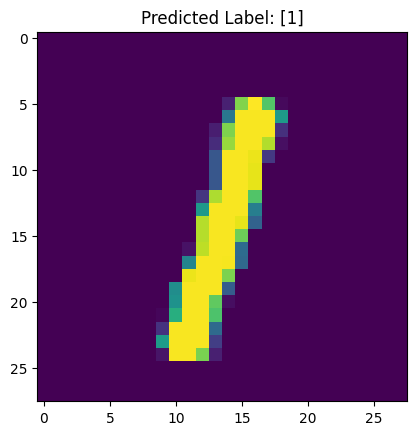

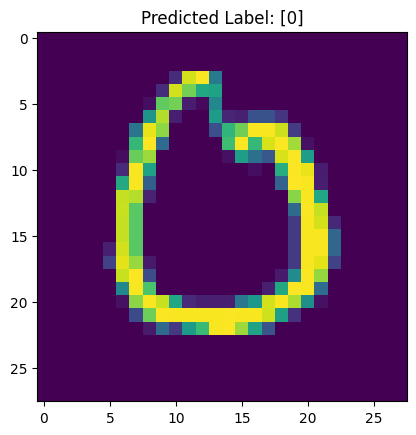

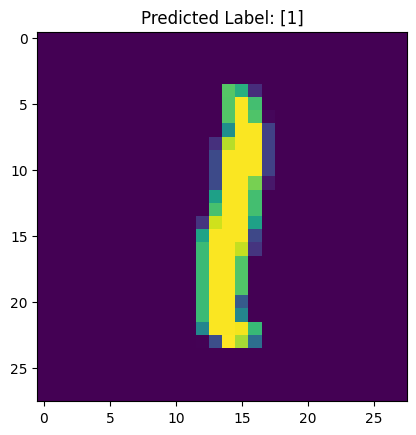

In [ ]:
### Use testing data to make prediction, feed forward ###

def print_prediction(image_dataset, flat_array):
    # Vector to pick random image/label pairs
    random_samples = np.random.randint(0, len(image_dataset), size=4)
    handle = 0  # Generic handle so multiple figs can be created
    
    for idx in random_samples:
        plt.figure(handle)
        handle += 1
        plt.imshow(image_dataset[idx,:,:])
        plt.title("Predicted Label: {}".format(clf.predict([flat_array[idx,:]])))

print_prediction(test_img_norm, test_img_norm_flat)


Using the `predict()` method, the model can make a guess of the value of each image in the testing dataset. This is computed using the softmax function, which is a derivative of the sigmoid function.